In [1]:
from qacits import calibrate_qacits, run_qacits
import heeps
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.io import fits

# 1/ Initialize L-CVC wavefront with HEEPS (24s, 100ms)

In [2]:
conf = dict(
    nframes = 240,
    dit = 0.1,
    band = 'L',
    mode = 'CVC',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_phase = 'wavefront/cube_Cfull_20211007_24s_100ms_0piston_meters_scao_only_L_285.fits',
    f_point_err = 'wavefront/point_all_24s_100ms_L.fits',
    ls_dRext = 0.0209,
    ls_dRint = 0.09,
    ls_dRspi = 0.0245,
    ls_ext_circ = False,
    ls_int_circ = False,
    add_point_err = True,
    )
conf = heeps.config.read_config(**conf)
conf = heeps.config.update_config(verbose=True, **conf)
wf = heeps.pupil.pupil(verbose=True, **conf)
phase_screens, amp_screens, tiptilts, apo_misaligns, ls_misaligns = \
    heeps.wavefront.load_errors(verbose=True, **conf)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   npupil=285, pscale=5.4700 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil from 'ELT_fullM1.fits'
Load phase screens from 'cube_Cfull_20211007_24s_100ms_0piston_meters_scao_only_L_285.fits'
   nscreens=240 (nframes=240, nstep=1)
Load pointing errors from 'point_all_24s_100ms_L.fits'
   nscreens=240


In [3]:
def create_psfs(conf, tiptilts, savefits=True, verbose=True):
    # off-axis PSF
    try:
        psf_OFF = fits.getdata(os.path.join(conf['dir_output'], 
            'offaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        psf_ON = fits.getdata(os.path.join(conf['dir_output'], 
            'onaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        print('Loading PSFs')
    except FileNotFoundError:
        psf_OFF = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=savefits, 
            verbose=verbose, **conf)
        psf_ON = heeps.wavefront.propagate_cube(wf, phase_screens, amp_screens, tiptilts, 
            apo_misaligns, ls_misaligns, onaxis=True, savefits=savefits, verbose=verbose, **conf)
    return psf_ON, psf_OFF

# 2/ QACITS calibration: known tip/tilt, no phase error

In [4]:
conf.update(
    dir_output = os.path.join(conf['dir_current'], 'calib'),
    add_phase = False,
    )

### Create calibration tip/tilt

calibration = 120 points in each direction


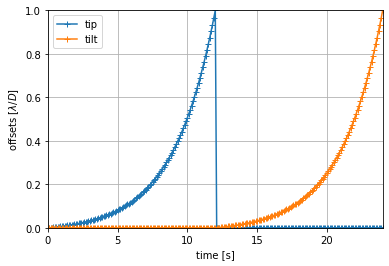

In [5]:
logb = .02
xy = np.logspace(np.log10(logb), np.log10(1 + logb), int(conf['nframes']/2)) - logb
tt_lamD = np.array([(x,0) for x in xy] + [(0,y) for y in xy])
x = (np.arange(conf['nframes']) + 1)*conf['dit']
print('calibration = %s points in each direction'%len(xy))
plt.plot(x, tt_lamD,'-+')
plt.legend(['tip', 'tilt'])
plt.xlim(0, x[-1])
plt.ylim(0, tt_lamD[-1,1])
plt.xlabel('time [s]')
plt.ylabel('offsets [$\lambda/D$]')
plt.grid(True), plt.grid(which='minor', linestyle=':');

### Generate PSFs using calibration tip/tilt

In [6]:
from heeps.util.lamD import get_lamD_mas, get_lamD_pix
from heeps.util.coord import mas2rms
# get image sampling
lamD_mas = get_lamD_mas(**conf)
lamD_pix = get_lamD_pix(**conf)
print('lambda/D = %.2f mas = %.2f pix'%(lamD_mas, lamD_pix))
# convert tip/tilt to mas, then to rms
tt_rms = mas2rms(tt_lamD*lamD_mas, conf['diam_ext'])
# create/load PSFs
psf_ON, psf_OFF = create_psfs(conf, tt_rms)

lambda/D = 21.78 mas = 3.98 pix
Create single off-axis PSF
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.0209, 0.09, 0.0245], ls_misalign=None
   extract PSF on the detector: ndet=403
Create on-axis PSF cube
   preloading Lyot stop, ls_misalign=None
   2022-05-30 17:43:42, e2e simulation using 12 cores
   2022-05-30 17:45:30, completed in 108.43 seconds


### Calibrate QACITS

psf_flux = 0.42397 (photutils = True)

Model calibration results:
Inner slope = 0.102
Outer slope = 0.072
Full coeff  = 1.471


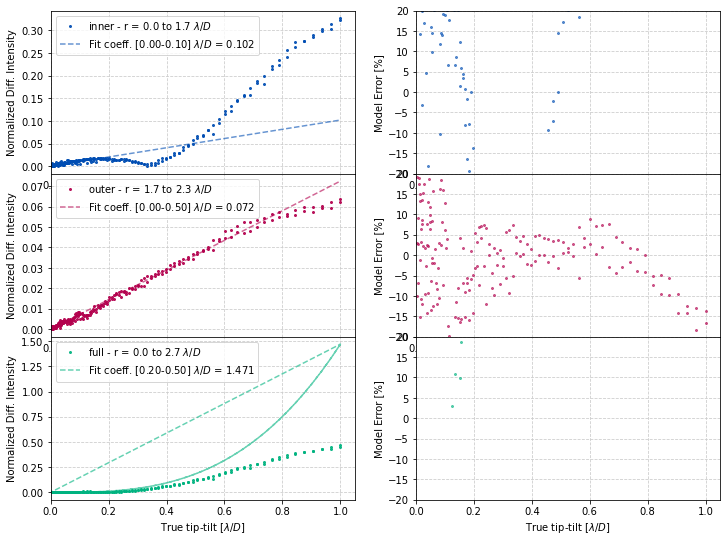

In [7]:
calib_tt = np.sqrt(tt_lamD[:,0]**2 + tt_lamD[:,1]**2)
coeffs = calibrate_qacits(psf_ON, psf_OFF, lamD_pix, calib_tt, verbose=True)

In [8]:
coeffs

{'inner': 0.10195462491666674,
 'outer': 0.07247409421765948,
 'full': 1.4709035685890728}

# 3/ Run QACITS in real conditions
### Generate PSFs with random tip/tilt and SCAO residuals